# Predicting Accident severity in the City of Seattle

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Importing and Cleaning Dataset](#0)<br>
2. [Exploratory Data Analysis](#2)<br>
3. [Predictive Modelling](#4) <br>
</div>
<hr>

# Importing and Cleaning Dataset<a id="0"></a>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv(r'C:\Users\DCOMP\Desktop\Coursera\IBM Data Science Certificate\Project Capstone\Data-Collisions.csv')

In [3]:
# keep the original data frame unchanged
# from this point onward work with df_mod
df_mod=df.copy()
df_mod.shape

(194673, 38)

In [4]:
# drop the columns: accident keys and IDs, duplicate columns, description columns that have a correspondng numeric column
df_mod.drop(['OBJECTID','INCKEY','COLDETKEY','REPORTNO','INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','STATUS',
         'SEVERITYCODE.1','SEVERITYDESC','SDOT_COLDESC','SDOTCOLNUM','ST_COLDESC','ST_COLCODE'],axis=1,inplace=True)

# drop "LOCATION" since we have the X,Y coordinates
df_mod.drop(['LOCATION'],axis=1,inplace=True)



In [5]:
# check the null values
null_counts = df_mod.isnull().sum()
null_counts

SEVERITYCODE           0
X                   5334
Y                   5334
ADDRTYPE            1926
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

In [6]:
# the following 3 columns have most of the values missing, so the best option is to drop them 
df_mod.drop(['INATTENTIONIND','PEDROWNOTGRNT','SPEEDING'],axis=1,inplace=True)

In [7]:
# replace X and Y missing values with average value
df_mod["X"].fillna(df_mod.X.mean(),inplace=True)
df_mod["Y"].fillna(df_mod.X.mean(),inplace=True)

In [8]:
# replace missing values with frequency
df_mod["ADDRTYPE"].fillna(df_mod.ADDRTYPE.value_counts().keys()[0],inplace=True)
df_mod["COLLISIONTYPE"].fillna(df_mod.COLLISIONTYPE.value_counts().keys()[0],inplace=True)
df_mod["JUNCTIONTYPE"].fillna(df_mod.JUNCTIONTYPE.value_counts().keys()[0],inplace=True)
df_mod["WEATHER"].fillna(df_mod.WEATHER.value_counts().keys()[0],inplace=True)
df_mod["ROADCOND"].fillna(df_mod.ROADCOND.value_counts().keys()[0],inplace=True)
df_mod["LIGHTCOND"].fillna(df_mod.LIGHTCOND.value_counts().keys()[0],inplace=True)
df_mod["UNDERINFL"].fillna(df_mod.UNDERINFL.value_counts().keys()[0],inplace=True)

In [9]:
# convert categorical columns to numeric
a=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']
for col in a:
    df_mod[col].replace(to_replace=df_mod[col].unique(), value=range(0,len(df_mod[col].unique())),inplace=True)

In [10]:
df_mod.dtypes

SEVERITYCODE       int64
X                float64
Y                float64
ADDRTYPE           int64
COLLISIONTYPE      int64
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
INCDATE           object
INCDTTM           object
JUNCTIONTYPE       int64
SDOT_COLCODE       int64
UNDERINFL         object
WEATHER            int64
ROADCOND           int64
LIGHTCOND          int64
SEGLANEKEY         int64
CROSSWALKKEY       int64
HITPARKEDCAR      object
dtype: object

In [11]:
# replace Y and N with 0 and 1 for the columns UNDERINFL and HITPARKEDCAR
df_mod.UNDERINFL.replace(to_replace ="N", value =0,inplace=True) 
df_mod.UNDERINFL.replace(to_replace ="Y", value =1,inplace=True)
df_mod.HITPARKEDCAR.replace(to_replace ="N", value =0,inplace=True) 
df_mod.HITPARKEDCAR.replace(to_replace ="Y", value =1,inplace=True) 
# convert data types to int
df_mod["UNDERINFL"] = df_mod["UNDERINFL"].astype('int64')
df_mod["HITPARKEDCAR"] = df_mod["HITPARKEDCAR"].astype('int64')    

In [12]:
# extract year, month, day of the week and hour of the accident time 
df_mod['INCDATE'] = pd.to_datetime(df_mod['INCDATE'])
df_mod['INCDTTM'] = pd.to_datetime(df_mod['INCDTTM'])

df_mod['year'] = df_mod['INCDATE'].dt.year
df_mod['month'] = df_mod['INCDATE'].dt.month
df_mod['dayofweek'] = df_mod['INCDATE'].dt.dayofweek
df_mod['Hour'] = df_mod['INCDTTM'].dt.hour

# now we can drop columns INCDATE and INCDTTM
df_mod.drop(['INCDATE','INCDTTM'],axis=1,inplace=True)

# Exploratory Data Analysis<a id="2"></a>


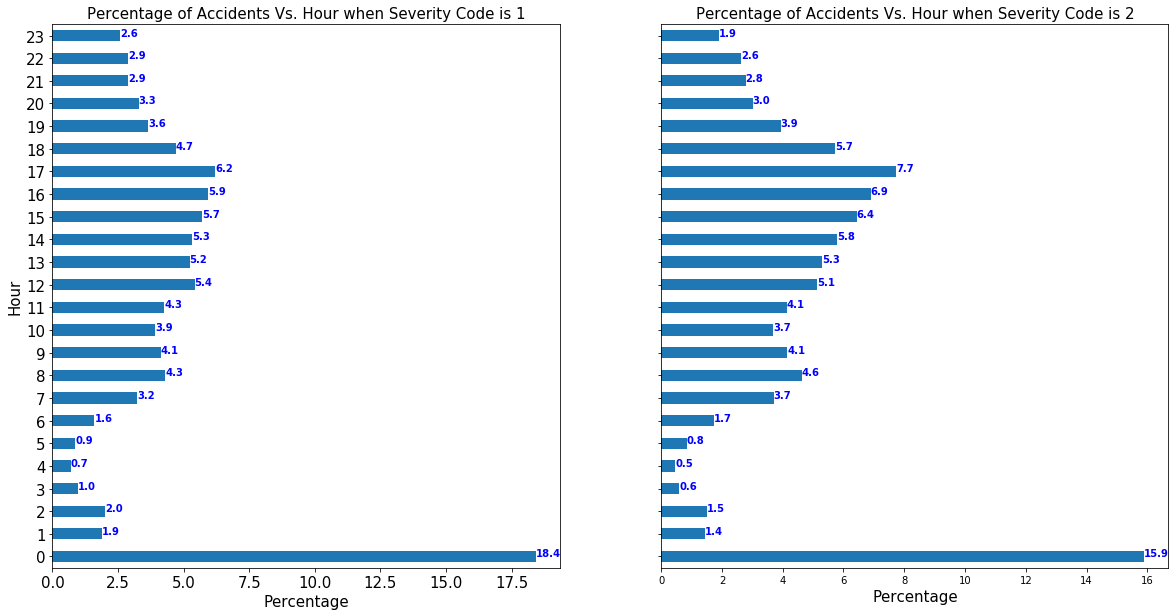

In [14]:
# Analyse the feature: Hour
a=df_mod[df_mod.SEVERITYCODE==1].Hour.value_counts(normalize=True,sort=False).sort_index()*100
b=df_mod[df_mod.SEVERITYCODE==2].Hour.value_counts(normalize=True,sort=False).sort_index()*100
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10),sharey=True)#, sharey=True)
a.plot(kind='barh',fontsize=15,ax=ax1)
ax1.set_title('Percentage of Accidents Vs. Hour when Severity Code is 1',fontsize=15)
ax2.set_title('Percentage of Accidents Vs. Hour when Severity Code is 2',fontsize=15)
ax1.set_xlabel('Percentage',fontsize=15)
ax2.set_xlabel('Percentage',fontsize=15)
ax1.set_ylabel('Hour',fontsize=15)
b.plot(kind='barh',fontsize=10,ax=ax2)
for i, v in enumerate(a):
    ax1.text(v, i, str(round(v,1)), color='blue', fontweight='bold')
for i, v in enumerate(b):
    ax2.text(v, i, str(round(v,1)), color='blue', fontweight='bold')

Text(0, 0.5, 'Address Type')

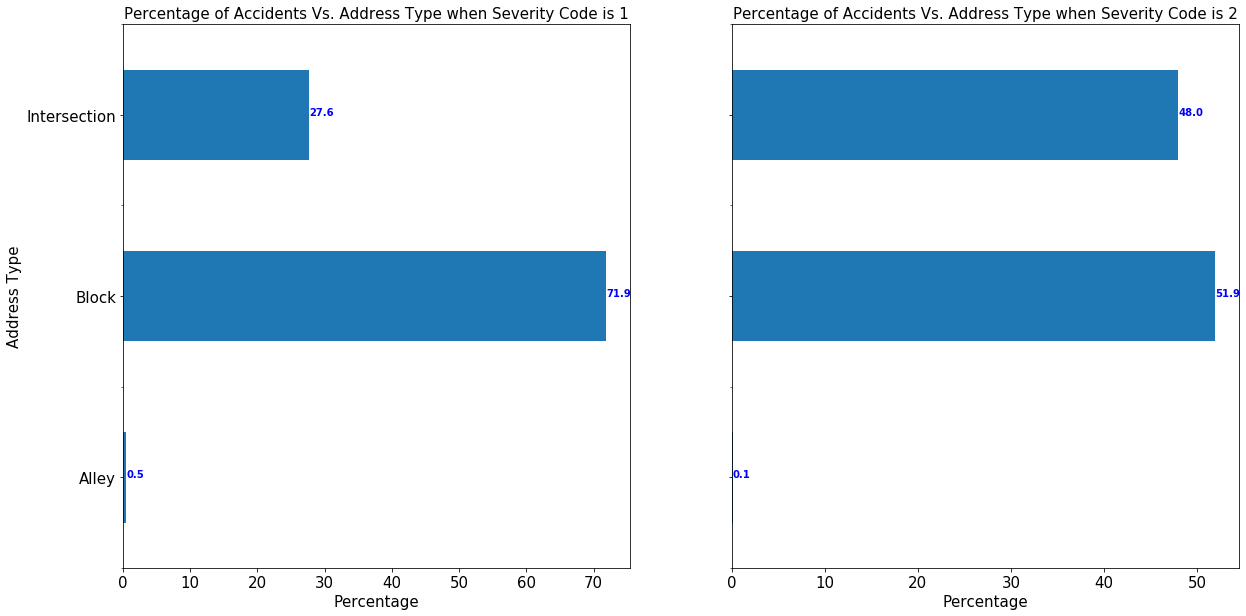

In [15]:
# Analyse the feature: ADDRTYPE
a=df[df.SEVERITYCODE==1].ADDRTYPE.value_counts(normalize=True,sort=False).sort_index()*100
b=df[df.SEVERITYCODE==2].ADDRTYPE.value_counts(normalize=True,sort=False).sort_index()*100
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10),sharey=True)#, sharey=True)
a.plot(kind='barh',fontsize=15,ax=ax1)
b.plot(kind='barh',fontsize=15,ax=ax2)
for i, v in enumerate(a):
    ax1.text(v, i, str(round(v,1)), color='blue', fontweight='bold')
for i, v in enumerate(b):
    ax2.text(v, i, str(round(v,1)), color='blue', fontweight='bold')
ax1.set_title('Percentage of Accidents Vs. Address Type when Severity Code is 1',fontsize=15)
ax2.set_title('Percentage of Accidents Vs. Address Type when Severity Code is 2',fontsize=15)
ax1.set_xlabel('Percentage',fontsize=15)
ax2.set_xlabel('Percentage',fontsize=15)
ax1.set_ylabel('Address Type',fontsize=15)

Text(0, 0.5, 'Collision Type')

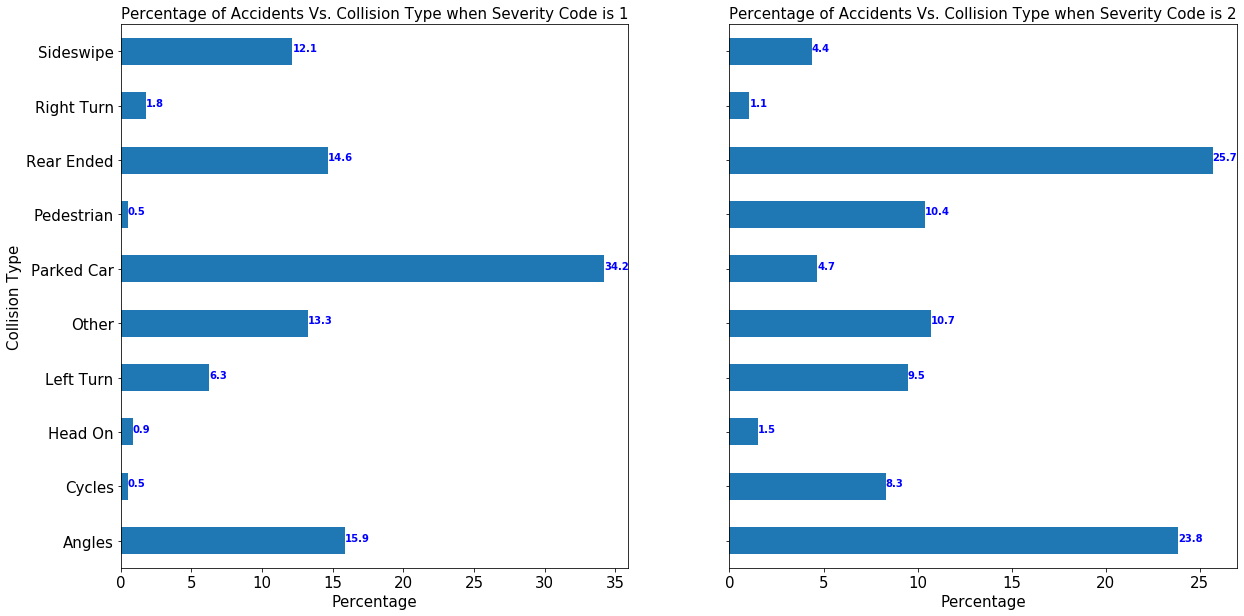

In [16]:
# Analyse the feature: COLLISIONTYPE
a=df[df.SEVERITYCODE==1].COLLISIONTYPE.value_counts(normalize=True,sort=False).sort_index()*100
b=df[df.SEVERITYCODE==2].COLLISIONTYPE.value_counts(normalize=True,sort=False).sort_index()*100
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10),sharey=True)#, sharey=True)
a.plot(kind='barh',fontsize=15,ax=ax1)
b.plot(kind='barh',fontsize=15,ax=ax2)

for i, v in enumerate(a):
    ax1.text(v, i, str(round(v,1)), color='blue', fontweight='bold')
for i, v in enumerate(b):
    ax2.text(v, i, str(round(v,1)), color='blue', fontweight='bold')
    
ax1.set_title('Percentage of Accidents Vs. Collision Type when Severity Code is 1',fontsize=15)
ax2.set_title('Percentage of Accidents Vs. Collision Type when Severity Code is 2',fontsize=15)
ax1.set_xlabel('Percentage',fontsize=15)
ax2.set_xlabel('Percentage',fontsize=15)
ax1.set_ylabel('Collision Type',fontsize=15)

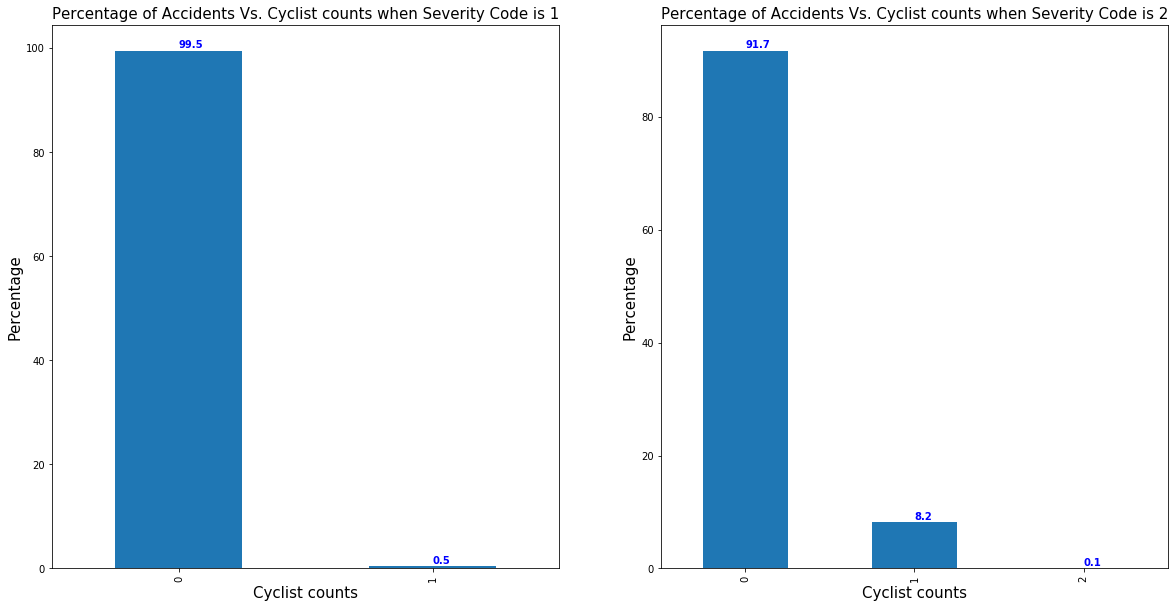

In [17]:
# Analyse the feature: PEDCYLCOUNT
a=df[df.SEVERITYCODE==1].PEDCYLCOUNT.value_counts(normalize=True,sort=False).sort_index()*100
b=df[df.SEVERITYCODE==2].PEDCYLCOUNT.value_counts(normalize=True,sort=False).sort_index()*100
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))#, sharey=True)
a.plot(kind='bar',fontsize=10,ax=ax1)
b.plot(kind='bar',fontsize=10,ax=ax2)
ax1.set_title('Percentage of Accidents Vs. Cyclist counts when Severity Code is 1',fontsize=15)
ax2.set_title('Percentage of Accidents Vs. Cyclist counts when Severity Code is 2',fontsize=15)
ax1.set_ylabel('Percentage',fontsize=15)
ax2.set_ylabel('Percentage',fontsize=15)
ax1.set_xlabel('Cyclist counts',fontsize=15)
ax2.set_xlabel('Cyclist counts',fontsize=15)

for i, v in enumerate(a):
    ax1.text(i, v+0.5, str(round(v,1)), color='blue', fontweight='bold')
for i, v in enumerate(b):
    ax2.text(i, v+0.5, str(round(v,1)), color='blue', fontweight='bold')
    

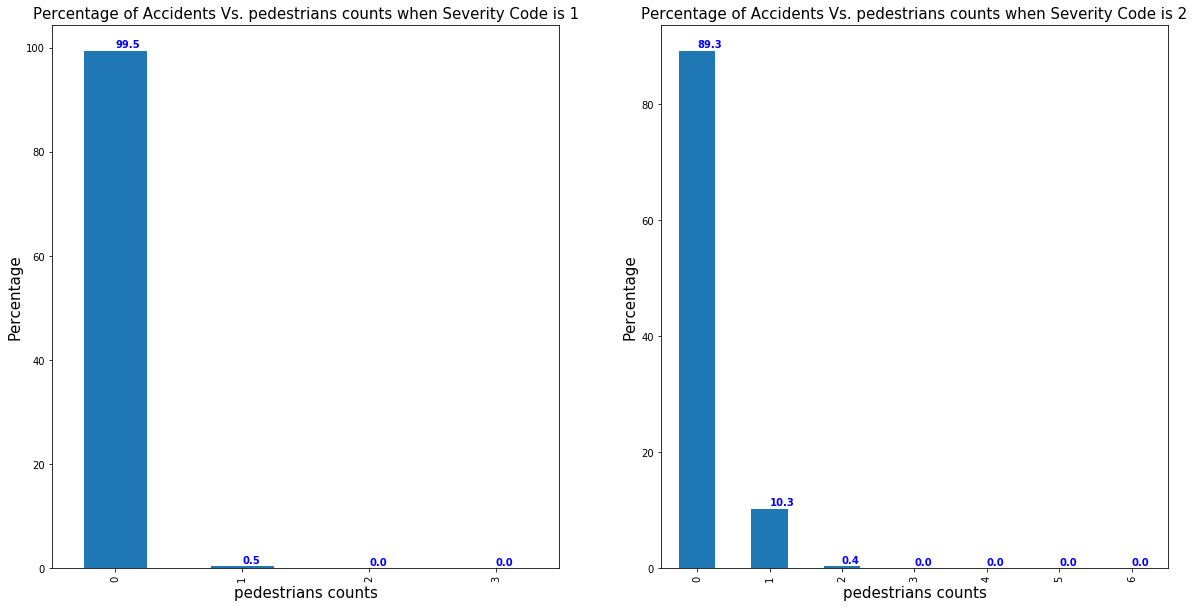

In [18]:
# Analyse the feature: PEDCOUNT
a=df_mod[df_mod.SEVERITYCODE==1].PEDCOUNT.value_counts(normalize=True,sort=False).sort_index()*100
b=df_mod[df_mod.SEVERITYCODE==2].PEDCOUNT.value_counts(normalize=True,sort=False).sort_index()*100
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))#, sharey=True)
a.plot(kind='bar',fontsize=10,ax=ax1)
b.plot(kind='bar',fontsize=10,ax=ax2)
ax1.set_title('Percentage of Accidents Vs. pedestrians counts when Severity Code is 1',fontsize=15)
ax2.set_title('Percentage of Accidents Vs. pedestrians counts when Severity Code is 2',fontsize=15)
ax1.set_ylabel('Percentage',fontsize=15)
ax2.set_ylabel('Percentage',fontsize=15)
ax1.set_xlabel('pedestrians counts',fontsize=15)
ax2.set_xlabel('pedestrians counts',fontsize=15)

for i, v in enumerate(a):
    ax1.text(i, v+0.5, str(round(v,1)), color='blue', fontweight='bold')
for i, v in enumerate(b):
    ax2.text(i, v+0.5, str(round(v,1)), color='blue', fontweight='bold')
    

# Predictive Modelling<a id="4"></a>

In [19]:
# selecting Features and target 
X=df_mod.copy()
X.drop('SEVERITYCODE',axis=1,inplace=True)

y = df_mod['SEVERITYCODE'].values

X= preprocessing.StandardScaler().fit(X).transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [33]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
yhat_log = LR.predict(X_test)
f1_log = f1_score(y_test, yhat_log , average='weighted') 
Jacc_log = jaccard_similarity_score(y_test, yhat_log)
f1_log,Jacc_log

(0.70825439727725, 0.752253756260434)

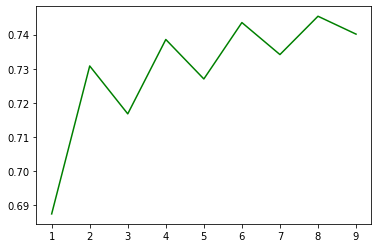

In [35]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
Ks = 10
mean_acc = np.zeros((Ks-1))
f1_knn = np.zeros((Ks-1))
Jacc_knn =  np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    f1_knn[n-1]=f1_score(y_test, yhat, average='weighted') 
    Jacc_knn[n-1] = jaccard_similarity_score(y_test, yhat)

plt.plot(range(1,Ks),mean_acc,'g')

plt.show()

In [36]:
f1_knn,Jacc_knn

(array([0.68758916, 0.6964127 , 0.70981155, 0.70977719, 0.71541766,
        0.71545532, 0.71918795, 0.71717339, 0.72267898]),
 array([0.68747913, 0.73080776, 0.71678438, 0.73856427, 0.72700655,
        0.74352125, 0.73414665, 0.74537049, 0.74013099]))

In [34]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DTree.fit(X,y)
predTree = DTree.predict(X)
metrics.accuracy_score(y, predTree)
f1_DTree = f1_score(y, predTree, average='weighted') 
Jacc_DTree = jaccard_similarity_score(y, predTree)
f1_DTree,Jacc_DTree

(0.7092984890276425, 0.7552048820329476)

In [28]:
# Support Vector Machine (SVM)
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
yhat_SVM = clf.predict(X_test)
f1_SVM = f1_score(y_test, yhat_SVM, average='weighted') 
Jacc_SVM = jaccard_similarity_score(y_test, yhat_SVM)
f1_SVM,Jacc_SVM


C:\Users\DCOMP\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\DCOMP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


(0.7162541187088435, 0.7603698471811995)